## Objetivo y alcance




Para esta materia el objetivo es poder hacer un primer acercamiento a un proceso de aprendizaje supervisado.

En este laboratorio no se espera que se encuentre el mejor modelo con sus mejores parámetros, sino que se logre la buena práctica de realizar los pasos necesarios en un proceso de aprendizaje supervisado, desde el entendimiento de la pregunta de investigación hasta la preparación de datos, desde la división del dataset hasta la evaluación del modelo. Para realizar el práctico vamos a utilizar el datasets que hayan generado en el práctico anterior.


## Introducción
En un mismo día une operador humano de una clínica responde cientos de consultas sobre problemáticas increiblemente sensibles como lo es la salud de una persona y las preocupaciones relacionadas a eso. Además la demanda de trabajo de un operador humano es multivariada y dinámica: algunos días hay un flujo mayor de pacientes usando los sistemas hospitalarios, y hay momentos del mes y del día en donde prácticamente no hay ninguna consulta a atender. 

El dato de **tiempo de respuesta de HH** tiene muchas implicaciones a nivel producto. Tener ese dato nos permite:
- informarle a la persona usuaria el tiempo promedio de respuesta antes de pasarla a hablar con une operador, para que adecúe sus expectativas a la realidad. 
- informarle detalladamente este dato a los hospitales como reporte de uso al final del mes, para que organice al grupo de trabajo eficientemente y con información veraz
- permitir configurar lógicas automáticas de repartición de tareas para les operadores, para facilitarles su trabajo

Por ello lo que se pretende en este práctico es poder armar un modelo que nos ayude a predecir el tiempo de respuesta de HH. Lo que nos da este dato es la presencia de la feature `Got_HH`, que cuando vale 1 nos marca en el dataset que el bot realizó la transferencia. El siguiente mensaje que tenga `Direction == outbound` sería el primer mensaje de un operador humano. La diferencia de horas entre estos dos mensajes nos da el tiempo de respuesta de un operador humano.

Predecir esta variable teniendo en cuenta las distintas features del dataset será una tarea de regresión. Entrenar un modelo por hospital dará una mejor predicción. Por conocimiento del dataset sabemos que entrenar por porción del día (mañana/tarde) también dará mejores resultados, pero esto es opcional.

## Tareas
En orden,

Deberán armar un dataset más pequeño que el actual, **sacando**:
- las filas de los hospitales sin HH (Demo, Desarrollo, Clínica Carrá, Default) y las conversaciones sin HH (que agrupadas por conv_id no tengan un Got_HH == 1)
- las conversaciones que nunca hayan pasado a HH (es decir Got_HH es 0 en toda la agrupación por conv_id) (guiarse con https://stackoverflow.com/questions/52393659/pandas-dataframe-check-if-column-value-exists-in-a-group-of-columns )
- Para simplificar, las conversaciones que hayan pasado a HH pero el operador nunca respondió. Es decir Got_HH es 1 en alguna fila, pero no hay una fila siguiente con direction igual a outbound.

**Generar** las features:

- `tiempo_de_respuesta_HH` (agrupando por conv_id, calcular el valor absoluto de la diferencia entre el SentDate del mensaje con Got_HH igual a 1 y el del siguiente mensaje con Direction igual a outbound https://stackoverflow.com/questions/34023918/make-new-column-in-panda-dataframe-by-adding-values-from-other-columns )
- cant de mensajes de la conversación (agrupación por conv_id+dia y luego sum) (https://stackoverflow.com/questions/39922986/how-do-i-pandas-group-by-to-get-sum)
- momento del dia (day_moment fue generada por el grupo 2 y puede reutilizarse el código que está aquí https://colab.research.google.com/drive/1KHgwiRqFLlavfhnCNdVvqG-xoPc0qMsM?usp=sharing#scrollTo=P04lwj2bSrFM )

**manteniendo** las features:

> - dia de la semana
> - fecha
> - presencia de errores en la conversación
> - hospital
> - cancelled
> - consulted
> - no correlation
> - y en general, todas las features que no sean body ni direction.
> - Debiendo quedar una fila por conversación.

* Cargar los datos, separando del dataset la etiqueta a predecir.
* Dividir el dataset en el conjunto de entrenamiento y conjunto de test
* Elegir y fundamentar si usar regresión lineal o polinomial(https://towardsdatascience.com/introduction-to-linear-regression-and-polynomial-regression-f8adc96f31cb, https://data36.com/polynomial-regression-python-scikit-learn/ ) . Tomarse un tiempito en hacer esta decisión les será muy útil ya que es una decisión interesante para comunicar en el video que tengan que hacer a partir de este práctico.
* Entrenar y evaluar un modelo de regresión lineal y uno polinomial, fijando la semilla aleatoria para hacer repetible el experimento.
* En cuanto a los hiper-parámetros:

        1.   Probar primero con los default y elegir alguna/s métrica/s para reportar los resultados. 
        2.   Luego usar grid-search (https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/) para explorar muchas combinaciones posibles de valores (Ejemplo de uso de grid search para encontrar el grado de polynomial regression https://stackoverflow.com/a/62460485/13597482 ). Reportar MAE y RMSE para las variaciones que busquen.

*   Para la mejor configuración encontrada, evaluar sobre el conjunto de entrenamiento y sobre el conjunto de evaluación, reportando MAE y RMSE.

### Se evaluarán los siguientes aspectos:
  ***1-*** Que se apliquen los conceptos vistos con los profes en el teórico y en el práctico.

  ***2-*** Capacidad de análisis. Enfocarse en esto les permitirá completar el video que deben preparar a continuación.

  ***3-*** Criterio para elegir que solución aplicar en cada caso y con qué método implementarla.


  
## Deadline pautado para la entrega: Miércoles 21/09/2022

Es importante que vayan anotando **conclusiones y observaciones en lenguaje natural** (no muy extensas) a medida que vayan realizando las tareas para que les sirva como **punto de partida para el video** de 10 min que se realice a partir de este práctico. El video que sigue a este práctico serviría como informe de resultados y observaciones de este práctico, resaltando aprendizajes y problemáticas con las que se hayan encontrado.

Lo importante de este práctico **no es encontrar el mejor modelo posible** ni mucho menos, sino poder ejercitar todo el proceso, que implica tanto **preparar los datos hasta correr los experimentos**, y finalmente **analizar y explicar los resultados encontrados**. En mi experiencia, la primera reacción ante saber que hay que comunicar resultados es querer comunicar éxitos, pero los resultados exitosos son -la mayoría de las veces- poco informativos. En el proceso de realización del práctico se encontrarán con desafíos de las tareas propuestas y con problemas específicos de este tipo de datasets conversacionales. Esa información es la valiosa a comunicar ya que es una experiencia que ningún otro grupo pudo tener, y le puede servir a otro grupo en un futuro que se relacione con datos que tengan características parecidas.

# Resolución

In [547]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib
import matplotlib.pyplot as plt

In [548]:
file_key_marzo = 'marzo_anon_test.csv'
file_key_febrero = 'febrero_anon_test.csv'

file_key_procesado = 'dataset_post_entrega_2.csv'

df_marzo = pd.read_csv(file_key_marzo)
df_febrero = pd.read_csv(file_key_febrero)

In [549]:
df = pd.concat([df_febrero, df_marzo]).drop(['Unnamed: 0'], axis=1)
df['SentDate'] = pd.to_datetime(df.SentDate)

In [550]:
df.sample(2)

,Hospital,Tel_hospital,Body,Status,SentDate,Fecha,Dia,Mes,Hora,Messages,...,Falla_Api_Externo,alta_dni,not_DNI,issue_name,Issue_Name,ask_kunan,Ask_Kunan,many_fallbacks_goto_hh,Many_Fallbacks_Goto_HH,conv_id
197105,Los Cedros,whatsapp:+5491120401203,¡Muchas gracias! Tus datos son: \n XXXXXXXXX...,read,2022-03-22 12:19:18+00:00,2022-03-22,22,3,12,1,...,0,[],0,[],0,[],0,[],0,5283
50271,Los Cedros,whatsapp:+5491120401203,Estamos fuera del horario de atención con oper...,read,2022-02-08 15:15:04+00:00,2022-02-08,8,2,15,1,...,0,[],0,[],0,[],0,[],0,1629


In [551]:
df.columns

Index(['Hospital', 'Tel_hospital', 'Body', 'Status', 'SentDate', 'Fecha',
       'Dia', 'Mes', 'Hora', 'Messages', 'Direction', 'Appointment_msp',
       'Appointment', 'Cancellation_msp', 'Cancelled', 'consult',
       'Consult_Appoint', 'fail_HH_sms', 'Fail_HH', 'achieve_HH', 'Got_HH',
       'Cupo', 'Full_turnos_obra_social', 'No_Relation', 'No_Correlation',
       'has_error', 'Error_Interno', 'has_error_501', 'Error_501',
       'falla_api_externo', 'Falla_Api_Externo', 'alta_dni', 'not_DNI',
       'issue_name', 'Issue_Name', 'ask_kunan', 'Ask_Kunan',
       'many_fallbacks_goto_hh', 'Many_Fallbacks_Goto_HH', 'conv_id'],
      dtype='object')

In [552]:
df.Dia.value_counts().reset_index().sort_values(by='index')

,index,Dia
22,1,4444
3,2,26475
6,3,23762
15,4,17148
23,5,3861
27,6,2598
2,7,29068
4,8,24688
13,9,20032
12,10,20222


### ¿Cómo se ven los mensajes de _Human Handoff_?
Buscamos una muestra de los mensajes que nos interesan, solo para ver que forma tienen

In [553]:
df_handoffed = df[df['Got_HH'] == 1]
df_handoffed[['conv_id', 'Body', 'Hospital', 'Direction']]

,conv_id,Body,Hospital,Direction
164,10,"Fuiste transferido a un humano, por favor escr...",CityBell,outbound-api
408,26,"Fuiste transferido a un humano, por favor escr...",CityBell,outbound-api
518,32,"Fuiste transferido a un humano, por favor escr...",CityBell,outbound-api
609,34,"Fuiste transferido a un humano, por favor escr...",Salud Consultorios,outbound-api
666,25,"Fuiste transferido a un humano, por favor escr...",CityBell,outbound-api
...,...,...,...,...
290219,4596,"Fuiste transferido a un humano, por favor escr...",CityBell,outbound-api
290339,7341,"Fuiste transferido a un humano, por favor escr...",CityBell,outbound-api
290660,7056,"Fuiste transferido a un humano, por favor escr...",CityBell,outbound-api
290921,7325,"Fuiste transferido a un humano, por favor escr...",CityBell,outbound-api


In [554]:
df_handoffed.Direction.value_counts()

outbound-api    2756
inbound            1
Name: Direction, dtype: int64

In [555]:
# Esto es un error ? 
df_handoffed[df_handoffed.Direction == 'inbound']

,Hospital,Tel_hospital,Body,Status,SentDate,Fecha,Dia,Mes,Hora,Messages,...,Falla_Api_Externo,alta_dni,not_DNI,issue_name,Issue_Name,ask_kunan,Ask_Kunan,many_fallbacks_goto_hh,Many_Fallbacks_Goto_HH,conv_id
197335,CityBell,whatsapp:+5492215137770,"Fuiste transferido a un humano, por favor escr...",received,2022-03-22 12:07:49+00:00,2022-03-22,22,3,12,1,...,0,[],0,[],0,[],0,[],0,4238


## ¿Cómo se vé una conversación que finaliza en _Human Handoff_?

Seleccionamos un valor de `conv_id` y `Hospital` como muestra para poder calcular el valor

In [556]:
# Nota:
# El valor de conv_id no es único.
df[df['conv_id'] == 32].Hospital.value_counts()

CityBell    56
Carra       22
Name: Hospital, dtype: int64

### Boceto: Calcular tiempo de respuesta para una única conversación

In [557]:
# Elegimos una conversación cualquiera, vemos que intercambio de mensajes hay

def get_sample(df, **kwargs):
    return df[(df['conv_id'] == kwargs['conv_id']) & (df['Hospital'] == kwargs['hospital'])][['Body','Direction','SentDate','Got_HH', 'Hospital']].sort_values(by='SentDate')


sample_conv_city_bell = get_sample(df, hospital = 'CityBell', conv_id = 32)
sample_conv_city_bell

,Body,Direction,SentDate,Got_HH,Hospital
6442,XXX,inbound,2022-02-16 11:45:35+00:00,0,CityBell
6437,XXXXXXXXXXXXX,inbound,2022-02-16 11:45:44+00:00,0,CityBell
6436,"Hola, soy el asistente virtual de Centro Medic...",outbound-api,2022-02-16 11:45:45+00:00,0,CityBell
6422,Sacar un turno,inbound,2022-02-16 11:46:04+00:00,0,CityBell
6421,"Necesito tu DNI, por favor.",outbound-api,2022-02-16 11:46:04+00:00,0,CityBell
6411,XXXXXXXX,inbound,2022-02-16 11:46:14+00:00,0,CityBell
6409,No se encuentra registrado ese DNI en el siste...,outbound-api,2022-02-16 11:46:16+00:00,0,CityBell
6408,¿Te puedo ayudar con algo más?,outbound-api,2022-02-16 11:46:16+00:00,0,CityBell
6395,Quiero hablar con un operador,inbound,2022-02-16 11:46:48+00:00,0,CityBell
6394,Has seleccionado una práctica que requiere ate...,outbound-api,2022-02-16 11:46:48+00:00,0,CityBell


In [558]:
# 7        Salud Consultorios
sample_conv_salud_c = get_sample(df, hospital = 'Salud Consultorios', conv_id = 7)
sample_conv_salud_c

,Body,Direction,SentDate,Got_HH,Hospital
173,XXXX,inbound,2022-03-01 19:33:58+00:00,0,Salud Consultorios
171,"Hola, soy el asistente virtual de Salud Consul...",outbound-api,2022-03-01 19:33:59+00:00,0,Salud Consultorios
165,Sacar turno,inbound,2022-03-01 19:34:20+00:00,0,Salud Consultorios
163,"Necesito tu DNI, por favor.",outbound-api,2022-03-01 19:34:21+00:00,0,Salud Consultorios
159,XXXXXXXXX,inbound,2022-03-01 19:34:28+00:00,0,Salud Consultorios
...,...,...,...,...,...
146584,No se pudo enviar el mensaje,outbound-api,2022-03-16 14:26:36+00:00,0,Salud Consultorios
146591,"Necesito hacer estos análisis, me podrían pasa...",inbound,2022-03-16 14:27:12+00:00,0,Salud Consultorios
146534,201.0,inbound,2022-03-16 14:30:12+00:00,0,Salud Consultorios
146234,Buenas tardes! para laboratorio debe comunicar...,outbound-api,2022-03-16 14:47:47+00:00,0,Salud Consultorios


In [559]:
def SentDate_delta(event, posteriores):
    """
    retorna el 
    """
    to = posteriores[(posteriores.Direction == 'outbound-api') & (posteriores.Got_HH == 0)]
    if not len(to):
        return None
    
    return to.head(1).SentDate - event.SentDate

# hh_machinery[T](data: DataFrame, handler: (t, []t): T): T 
def hh_machinery(data, handler = SentDate_delta):
    """
    hh_machinery[T](data: DataFrame, handler: (t, []t): T): T 
    data es un conjunto de mensajes pertenecientes a una misma conversación (para un mismo día y hospital)
    handler es una funcion que puede recibir un mensaje de human handoff y los posteriores a ese
    Retorna lo que devuelva handler: 
    
    Pre: data tiene al menos un mensaje con Got_HH en 1, los mensajes estan ordenados por SentDate
    """
    conv = data.reset_index()

    # Pre:conv tiene al menos un mensaje con Got_HH en 1
    handoff = conv[conv.Got_HH == 1]
    idx = handoff.index[0] 
    
    # Si es el último mensaje, no podemos obtener el tiempo buscado
    if idx == len(handoff):
        return None
        
    return handler(conv.iloc[idx], conv[idx:])

tiempo_de_respuesta_HH = lambda data: hh_machinery(data)

In [560]:
t2hh = tiempo_de_respuesta_HH(sample_conv_city_bell)
print (type(t2hh))

tiempo_de_respuesta_HH(sample_conv_city_bell).iloc[0]

<class 'pandas.core.series.Series'>


Timedelta('0 days 00:03:25')

In [561]:
print (tiempo_de_respuesta_HH(sample_conv_city_bell))

# salud consultorios, conv id = 7 
print (tiempo_de_respuesta_HH(sample_conv_salud_c))


34   0 days 00:03:25
Name: SentDate, dtype: timedelta64[ns]
56   0 days 00:00:37
Name: SentDate, dtype: timedelta64[ns]


Ahora tenemos una muestra de como calcular el tiempo de respuesta para una conversación. En las siguientes secciones vamos a trabajar en filtrar los datos para considerar unicamente conversaciones con una ocurrencia de `Got_HH == 1`

## Filtro de conversaciones

In [563]:
def with_human_handoff(df):
  """
  Filter conversations which where 'human handoffed'
  """
  c = df.groupby(by = ['conv_id', 'Fecha', 'Hospital'])[[ 'Got_HH']].sum()
  return c[c.Got_HH > 0]

In [564]:
hhs = with_human_handoff(df_handoffed)
len(hhs[hhs.Got_HH == 1]), len(hhs[hhs.Got_HH > 1])


(2472, 135)

In [565]:
# Nos quedamos únicamente con las conversaciones que tienen un único pasaje a humano
hhs = hhs[hhs.Got_HH == 1].reset_index().rename(columns = {"Got_HH": "Got_HH_sum"})
hhs

,conv_id,Fecha,Hospital,Got_HH_sum
0,7,2022-03-16,Salud Consultorios,1
1,10,2022-02-16,CityBell,1
2,11,2022-02-16,Salud Consultorios,1
3,13,2022-02-23,CityBell,1
4,17,2022-02-15,Salud Consultorios,1
...,...,...,...,...
2467,7410,2022-03-31,Salud Consultorios,1
2468,7422,2022-03-31,Salud Consultorios,1
2469,7424,2022-03-31,Salud Consultorios,1
2470,7438,2022-03-31,CityBell,1


### Seguimos mirando
A partir del índice del paso anterior podemos filtrar los grupos de interes en el dataframe general

In [566]:
x = df.merge(hhs, on = ['conv_id', 'Fecha', 'Hospital'])
x

,Hospital,Tel_hospital,Body,Status,SentDate,Fecha,Dia,Mes,Hora,Messages,...,alta_dni,not_DNI,issue_name,Issue_Name,ask_kunan,Ask_Kunan,many_fallbacks_goto_hh,Many_Fallbacks_Goto_HH,conv_id,Got_HH_sum
0,CityBell,whatsapp:+5492215137770,Hola! Este es un mensaje automático. Me encuen...,received,2022-02-16 19:33:19+00:00,2022-02-16,16,2,19,1,...,[],0,[],0,[],0,[],0,10,1
1,CityBell,whatsapp:+5492215137770,"Buenas tardes, por favor enviar los datos requ...",delivered,2022-02-16 19:33:17+00:00,2022-02-16,16,2,19,1,...,[],0,[],0,[],0,[],0,10,1
2,CityBell,whatsapp:+5492215137770,Necesito hacerme un electrocardiograma,received,2022-02-16 19:22:00+00:00,2022-02-16,16,2,19,1,...,[],0,[],0,[],0,[],0,10,1
3,CityBell,whatsapp:+5492215137770,"Fuiste transferido a un humano, por favor escr...",delivered,2022-02-16 19:21:47+00:00,2022-02-16,16,2,19,1,...,[],0,[],0,[],0,[],0,10,1
4,CityBell,whatsapp:+5492215137770,Has seleccionado una práctica que requiere ate...,delivered,2022-02-16 19:21:47+00:00,2022-02-16,16,2,19,1,...,[],0,[],0,[],0,[],0,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76403,CityBell,whatsapp:+5492215137770,"Necesito tu DNI, por favor.",read,2022-03-31 09:25:03+00:00,2022-03-31,31,3,9,1,...,[],0,[],0,[],0,[],0,7235,1
76404,CityBell,whatsapp:+5492215137770,Sacar turno,received,2022-03-31 09:25:03+00:00,2022-03-31,31,3,9,1,...,[],0,[],0,[],0,[],0,7235,1
76405,CityBell,whatsapp:+5492215137770,"Hola, soy el asistente virtual de Centro Medic...",read,2022-03-31 09:24:43+00:00,2022-03-31,31,3,9,1,...,[],0,[],0,[],0,[],0,7235,1
76406,CityBell,whatsapp:+5492215137770,Tu sesión se ha reinciado por tiempo de inacti...,read,2022-03-31 09:24:43+00:00,2022-03-31,31,3,9,1,...,[],0,[],0,[],0,[],0,7235,1


In [567]:
x.columns

Index(['Hospital', 'Tel_hospital', 'Body', 'Status', 'SentDate', 'Fecha',
       'Dia', 'Mes', 'Hora', 'Messages', 'Direction', 'Appointment_msp',
       'Appointment', 'Cancellation_msp', 'Cancelled', 'consult',
       'Consult_Appoint', 'fail_HH_sms', 'Fail_HH', 'achieve_HH', 'Got_HH',
       'Cupo', 'Full_turnos_obra_social', 'No_Relation', 'No_Correlation',
       'has_error', 'Error_Interno', 'has_error_501', 'Error_501',
       'falla_api_externo', 'Falla_Api_Externo', 'alta_dni', 'not_DNI',
       'issue_name', 'Issue_Name', 'ask_kunan', 'Ask_Kunan',
       'many_fallbacks_goto_hh', 'Many_Fallbacks_Goto_HH', 'conv_id',
       'Got_HH_sum'],
      dtype='object')

In [568]:
x[x.Got_HH == 1][['Got_HH','Got_HH_sum']]
x.sample(3)

,Hospital,Tel_hospital,Body,Status,SentDate,Fecha,Dia,Mes,Hora,Messages,...,alta_dni,not_DNI,issue_name,Issue_Name,ask_kunan,Ask_Kunan,many_fallbacks_goto_hh,Many_Fallbacks_Goto_HH,conv_id,Got_HH_sum
15747,CityBell,whatsapp:+5492215137770,Horario de preferencia después de las 17,received,2022-02-15 14:34:29+00:00,2022-02-15,15,2,14,1,...,[],0,[],0,[],0,[],0,170,1
33901,Santa Fe,whatsapp:+5493424134455,*Escribe el número de la opción* que quieres e...,read,2022-03-03 12:10:40+00:00,2022-03-03,3,3,12,1,...,[],0,[],0,[],0,[],0,870,1
27056,CityBell,whatsapp:+5492215137770,tomas alguno?,read,2022-02-24 14:08:09+00:00,2022-02-24,24,2,14,1,...,[],0,[],0,[],0,[],0,4945,1


In [569]:
x.columns

Index(['Hospital', 'Tel_hospital', 'Body', 'Status', 'SentDate', 'Fecha',
       'Dia', 'Mes', 'Hora', 'Messages', 'Direction', 'Appointment_msp',
       'Appointment', 'Cancellation_msp', 'Cancelled', 'consult',
       'Consult_Appoint', 'fail_HH_sms', 'Fail_HH', 'achieve_HH', 'Got_HH',
       'Cupo', 'Full_turnos_obra_social', 'No_Relation', 'No_Correlation',
       'has_error', 'Error_Interno', 'has_error_501', 'Error_501',
       'falla_api_externo', 'Falla_Api_Externo', 'alta_dni', 'not_DNI',
       'issue_name', 'Issue_Name', 'ask_kunan', 'Ask_Kunan',
       'many_fallbacks_goto_hh', 'Many_Fallbacks_Goto_HH', 'conv_id',
       'Got_HH_sum'],
      dtype='object')

In [570]:
def momento(request_HH, posteriores):
    time_to_hh = SentDate_delta(request_HH, posteriores)
    if time_to_hh is None:
        return None
    
    
    time2HH = time_to_hh.iloc[0]

    hora = request_HH.Hora
    if 1 <= hora <= 5:
        return ('Madrugada', time2HH)
    elif 6 <= hora <= 12:
        return ('Mañana', time2HH)
    elif 13 <= hora <= 19:
        return ('Tarde', time2HH)
    elif (20 <= hora <= 23) or (hora == 0):
        return ('Noche', time2HH)
    
    print(f"no such time {hora}")
    return None
    
tiempo_de_respuesta_HH_con_momento = lambda data: hh_machinery(data, handler = momento)

def conv_digest(df):
    g = df.groupby(by = ['conv_id', 'Hospital', 'Fecha'])

    for each in list(g.groups)[:]:
        data = g.get_group(each).sort_values(by='SentDate')
        info = tiempo_de_respuesta_HH_con_momento(data)
        if info is None:
            continue
            
        momento, time2HH = info
        c = data.Messages.sum()
            
        yield each + (momento, time2HH, c)

    

In [571]:

col_names = ['conv_id', 'Hospital', 'Fecha', 'day_moment', 'Tiempo_de_respuesta_HH', 'Num_mensajes']

aggs = pd.DataFrame(conv_digest(x), columns = col_names)
aggs

,conv_id,Hospital,Fecha,day_moment,Tiempo_de_respuesta_HH,Num_mensajes
0,7,Salud Consultorios,2022-03-16,Tarde,0 days 00:00:37,24
1,10,CityBell,2022-02-16,Tarde,0 days 00:00:00,16
2,11,Salud Consultorios,2022-02-16,Mañana,0 days 09:07:25,31
3,13,CityBell,2022-02-23,Tarde,0 days 00:00:00,14
4,17,Salud Consultorios,2022-02-15,Mañana,0 days 00:20:09,53
...,...,...,...,...,...,...
2164,7403,CityBell,2022-03-31,Mañana,0 days 01:09:13,23
2165,7410,Salud Consultorios,2022-03-31,Mañana,0 days 00:56:37,22
2166,7422,Salud Consultorios,2022-03-31,Mañana,0 days 00:03:29,28
2167,7424,Salud Consultorios,2022-03-31,Mañana,0 days 00:05:42,26


In [572]:
aggs.describe()

,conv_id,Tiempo_de_respuesta_HH,Num_mensajes
count,2169.000000,2169,2169.000000
mean,3122.344398,0 days 00:27:37.650069156,31.394652
std,1998.569868,0 days 00:56:04.255917291,20.205519
min,7.000000,0 days 00:00:00,7.000000
25%,1373.000000,0 days 00:00:00,19.000000
50%,3055.000000,0 days 00:06:03,25.000000
75%,4596.000000,0 days 00:27:37,37.000000
max,7438.000000,0 days 09:37:49,224.000000


Vemos que existen algunos valores de tiempo de respuesta inmediatos (`0 segundos`). Analizamos un caso particular para entender que está pasando

In [573]:
aggs.sort_values(by='Tiempo_de_respuesta_HH')

,conv_id,Hospital,Fecha,day_moment,Tiempo_de_respuesta_HH,Num_mensajes
2168,7438,CityBell,2022-03-31,Mañana,0 days 00:00:00,13
1228,3467,CityBell,2022-03-14,Tarde,0 days 00:00:00,17
431,1088,Salud Consultorios,2022-02-11,Tarde,0 days 00:00:00,16
432,1089,CityBell,2022-02-04,Mañana,0 days 00:00:00,13
1227,3466,CityBell,2022-03-14,Tarde,0 days 00:00:00,16
...,...,...,...,...,...,...
2138,7295,CityBell,2022-03-31,Mañana,0 days 07:17:48,22
643,1699,CityBell,2022-03-22,Mañana,0 days 07:29:18,40
1200,3400,Salud Consultorios,2022-03-14,Mañana,0 days 08:38:48,39
2,11,Salud Consultorios,2022-02-16,Mañana,0 days 09:07:25,31


In [574]:
faulting = x[(x.conv_id == 3466) & (x.Hospital == 'CityBell') & (x.Fecha == '2022-03-14')]\
    .sort_values(by='SentDate')\
    .reset_index()
faulting
start = faulting[faulting.Got_HH == 1].index[0]


context = faulting[start-1:]

context[context.Direction == 'outbound-api'][['index', 'Got_HH', 'Body', 'SentDate']]


,index,Got_HH,Body,SentDate
13,49801,1,"Fuiste transferido a un humano, por favor escr...",2022-03-14 16:19:09+00:00
14,49802,0,Has seleccionado una práctica que requiere ate...,2022-03-14 16:19:09+00:00
15,49803,0,"Por la opción elegida, te transferiré con una ...",2022-03-14 16:19:09+00:00


Vamos a filtrar estos valores de nuestro conjunto de datos, aunque cumplen con el criterio provisto por la mentoria.

In [575]:
tiempo_de_respuesta_HH(faulting).iloc[0] == pd.Timedelta(value=0)

True

In [576]:

aggs = aggs[aggs.Tiempo_de_respuesta_HH != pd.Timedelta(value=0)].sort_values(by = 'Tiempo_de_respuesta_HH')
aggs.describe()

,conv_id,Tiempo_de_respuesta_HH,Num_mensajes
count,1520.000000,1520,1520.000000
mean,3087.291447,0 days 00:39:25.423026315,32.903947
std,1985.106197,0 days 01:03:25.088155911,19.996774
min,7.000000,0 days 00:00:01,14.000000
25%,1364.000000,0 days 00:05:04,21.000000
50%,2954.000000,0 days 00:15:47.500000,27.000000
75%,4504.000000,0 days 00:44:23.750000,37.000000
max,7424.000000,0 days 09:37:49,224.000000


### Dataset
Creamos el dataset para pasarle al regresor

In [577]:
join_columns = ['conv_id', 'Fecha', 'Hospital']

In [578]:
source = df.groupby(by=join_columns).sum().drop(labels = ['Dia', 'Mes'], axis = 1).reset_index()
source

,conv_id,Fecha,Hospital,Hora,Messages,Appointment,Cancelled,Consult_Appoint,Fail_HH,Got_HH,Full_turnos_obra_social,No_Correlation,Error_Interno,Error_501,Falla_Api_Externo,not_DNI,Issue_Name,Ask_Kunan,Many_Fallbacks_Goto_HH
0,0,2022-02-16,Carra,1276,75,1,0,0,0,0,4,0,0,0,0,0,0,0,0
1,0,2022-02-17,Carra,152,19,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,2022-02-19,Carra,325,25,1,0,0,1,0,0,0,0,0,0,0,0,0,1
3,0,2022-03-01,Carra,1403,67,0,0,0,0,0,9,0,0,0,0,0,0,0,0
4,0,2022-03-25,Carra,242,22,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18659,7483,2022-03-31,Carra,224,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18660,7484,2022-03-31,Los Cedros,112,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18661,7485,2022-03-31,Los Cedros,7,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18662,7486,2022-03-30,Carra,46,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [579]:
dataset = source.merge(aggs, on = ['conv_id', 'Fecha', 'Hospital']).sort_values(by='conv_id')

In [580]:
dataset.columns

Index(['conv_id', 'Fecha', 'Hospital', 'Hora', 'Messages', 'Appointment',
       'Cancelled', 'Consult_Appoint', 'Fail_HH', 'Got_HH',
       'Full_turnos_obra_social', 'No_Correlation', 'Error_Interno',
       'Error_501', 'Falla_Api_Externo', 'not_DNI', 'Issue_Name', 'Ask_Kunan',
       'Many_Fallbacks_Goto_HH', 'day_moment', 'Tiempo_de_respuesta_HH',
       'Num_mensajes'],
      dtype='object')

In [581]:
dataset.sample(10)

,conv_id,Fecha,Hospital,Hora,Messages,Appointment,Cancelled,Consult_Appoint,Fail_HH,Got_HH,...,Error_Interno,Error_501,Falla_Api_Externo,not_DNI,Issue_Name,Ask_Kunan,Many_Fallbacks_Goto_HH,day_moment,Tiempo_de_respuesta_HH,Num_mensajes
601,2233,2022-02-10,CityBell,267,26,0,0,0,0,1,...,0,0,0,1,0,0,0,Mañana,0 days 02:55:01,26
249,922,2022-02-21,Salud Consultorios,409,35,0,0,0,0,1,...,0,0,0,0,0,0,0,Mañana,0 days 00:29:46,35
807,3179,2022-02-23,Salud Consultorios,217,24,0,0,0,0,1,...,0,0,1,1,0,0,1,Mañana,0 days 01:00:05,24
666,2559,2022-02-14,CityBell,343,26,0,0,0,0,1,...,0,0,0,0,0,0,1,Tarde,0 days 05:09:17,26
624,2336,2022-02-11,CityBell,620,35,0,0,0,0,1,...,0,0,0,2,0,0,1,Tarde,0 days 00:01:03,35
609,2261,2022-03-08,Salud Consultorios,309,28,0,0,0,0,1,...,0,0,0,0,0,0,0,Mañana,0 days 00:21:23,28
1384,6193,2022-03-30,CityBell,321,32,0,0,0,0,1,...,0,0,0,0,0,0,0,Mañana,0 days 03:25:22,32
1249,5026,2022-02-24,CityBell,270,27,0,0,0,0,1,...,0,0,0,2,0,0,0,Mañana,0 days 00:08:54,27
846,3378,2022-03-14,CityBell,434,26,0,0,0,0,1,...,0,0,0,2,0,0,0,Tarde,0 days 00:00:36,26
1250,5036,2022-03-21,Salud Consultorios,210,17,0,0,0,0,1,...,0,0,0,1,0,0,0,Mañana,0 days 01:50:48,17


In [582]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1520 entries, 0 to 1519
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   conv_id                  1520 non-null   int64          
 1   Fecha                    1520 non-null   object         
 2   Hospital                 1520 non-null   object         
 3   Hora                     1520 non-null   int64          
 4   Messages                 1520 non-null   int64          
 5   Appointment              1520 non-null   int64          
 6   Cancelled                1520 non-null   int64          
 7   Consult_Appoint          1520 non-null   int64          
 8   Fail_HH                  1520 non-null   int64          
 9   Got_HH                   1520 non-null   int64          
 10  Full_turnos_obra_social  1520 non-null   int64          
 11  No_Correlation           1520 non-null   int64          
 12  Error_Interno       

In [583]:
dataset.Fecha.sample(4)

1033    2022-02-21
1335    2022-03-23
476     2022-03-29
825     2022-03-12
Name: Fecha, dtype: object

## Análisis de las variables generadas

### Momentos

In [769]:
dataset.Messages.describe()

count    1520.000000
mean       32.903947
std        19.996774
min        14.000000
25%        21.000000
50%        27.000000
75%        37.000000
max       224.000000
Name: Messages, dtype: float64

In [775]:
dataset.day_moment.value_counts()

Mañana    761
Tarde     759
Name: day_moment, dtype: int64

## Análisis de la variable objetivo

### Momentos
¿Cómo se distribuye la variable objetivo? Vemos que hasta el percentil 75% los valores son esperables (aunque 45 minutos de espera puede ser un tanto molesto)

In [667]:
dataset.Tiempo_de_respuesta_HH.describe()

count                         1520
mean     0 days 00:39:25.423026315
std      0 days 01:03:25.088155911
min                0 days 00:00:01
25%                0 days 00:05:04
50%         0 days 00:15:47.500000
75%         0 days 00:44:23.750000
max                0 days 09:37:49
Name: Tiempo_de_respuesta_HH, dtype: object

### Correlación con otras variables
Nos interesa realizar un análisis sobre la correlación entre el Tiempo de respuesta y el resto de las variables, de forma de tener cierta idea sobre qué esperar de nuestro regresor.



In [585]:
dataset.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)['Tiempo_de_respuesta_HH']

conv_id                    0.817707
Fecha                      0.252263
Hospital                   0.019894
Hora                       0.360581
Messages                   0.005940
Appointment               -0.073940
Cancelled                 -0.023084
Consult_Appoint           -0.025762
Fail_HH                    0.019611
Got_HH                          NaN
Full_turnos_obra_social   -0.005714
No_Correlation             0.020500
Error_Interno              0.040202
Error_501                  0.037144
Falla_Api_Externo         -0.023916
not_DNI                    0.067666
Issue_Name                -0.037555
Ask_Kunan                       NaN
Many_Fallbacks_Goto_HH    -0.003462
day_moment                 0.032021
Tiempo_de_respuesta_HH     1.000000
Num_mensajes               0.005940
Name: Tiempo_de_respuesta_HH, dtype: float64

In [586]:
print(dataset.Tiempo_de_respuesta_HH)

0      0 days 00:00:37
1      0 days 09:07:25
2      0 days 00:20:09
3      0 days 00:07:42
4      0 days 00:07:26
             ...      
1515   0 days 00:10:31
1516   0 days 01:09:13
1517   0 days 00:56:37
1518   0 days 00:03:29
1519   0 days 00:05:42
Name: Tiempo_de_respuesta_HH, Length: 1520, dtype: timedelta64[ns]


In [687]:
tiempo_de_respuesta_seconds = dataset.Tiempo_de_respuesta_HH.values / np.timedelta64(1, 's')


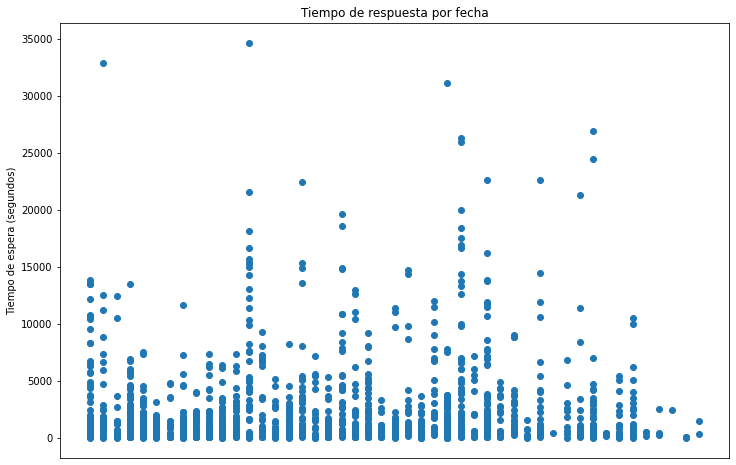

In [686]:
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(dataset.Fecha, tiempo_de_respuesta_seconds)

ax.set_ylabel('Tiempo de espera (segundos)')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.title('Tiempo de respuesta por fecha')
plt.show()

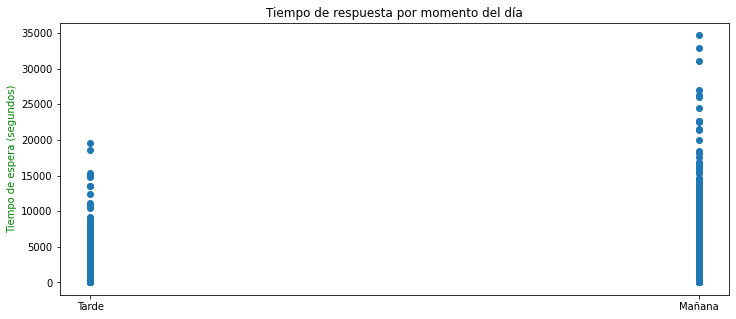

In [700]:
fig, ax = plt.subplots(figsize=(12, 5))
scatter = ax.scatter(dataset.day_moment, tiempo_de_respuesta_seconds)

ax.set_ylabel('Tiempo de espera (segundos)', color='g')
plt.title('Tiempo de respuesta por momento del día')
plt.show()

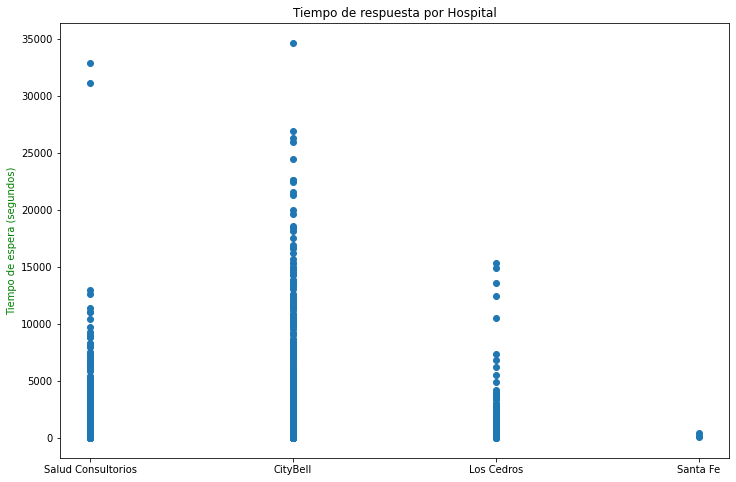

In [698]:
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(dataset.Hospital, tiempo_de_respuesta_seconds)

ax.set_ylabel('Tiempo de espera (segundos)', color='g')
plt.title('Tiempo de respuesta por Hospital')
plt.show()

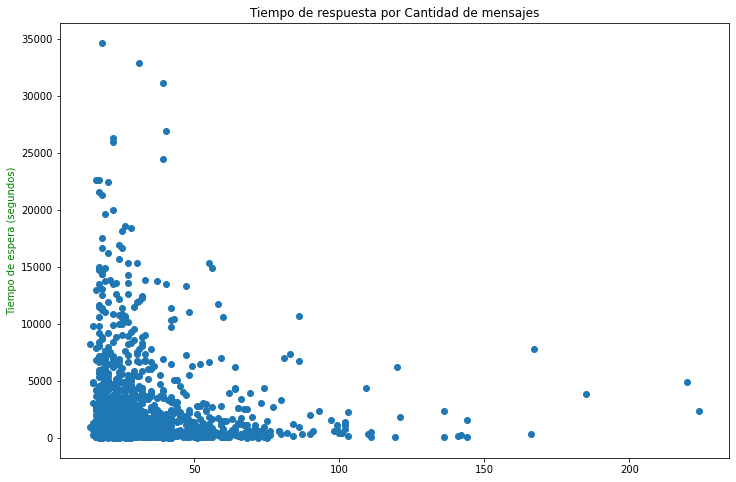

In [703]:
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(dataset.Messages, tiempo_de_respuesta_seconds)

ax.set_ylabel('Tiempo de espera (segundos)', color='g')
plt.title('Tiempo de respuesta por Cantidad de mensajes')
plt.show()

----

## Regresion lineal

In [590]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 

### Transformación de los datos
Antes de entrenar el regresor vamos a codificar las varibles no numéricas
* Hospital
* Fecha
* Tiempo de respuesta
* Momento del día

#### Hospital 
Dado que se trata de un conjunto reducido de valores, utilizamos `OneHotEncoding`

In [591]:
one_hot_encoder = OneHotEncoder()
encoded_hospital = one_hot_encoder.fit_transform(dataset.Hospital.values.reshape(-1, 1))
encoded_hospital_df = pd.DataFrame(data = encoded_hospital.toarray(), columns = one_hot_encoder.categories_[0])

encoded_hospital_df.sample(3)

,CityBell,Los Cedros,Salud Consultorios,Santa Fe
1154,1.0,0.0,0.0,0.0
728,1.0,0.0,0.0,0.0
184,0.0,0.0,1.0,0.0


#### Momento del día
Utilizamos `OneHotEncoding` aprovechando el hecho de que es un conjunto de valores acotado

In [592]:
one_hot_encoder = OneHotEncoder()
encoded_moment = one_hot_encoder.fit_transform(dataset.day_moment.values.reshape(-1, 1))
encoded_moment_df = pd.DataFrame(data = encoded_moment.toarray(), columns = one_hot_encoder.categories_[0])
encoded_moment_df.sample(3)

,Mañana,Tarde
161,1.0,0.0
591,1.0,0.0
1203,1.0,0.0


#### Fecha 
Para codificar la fecha vamos a asignar una etiqueta numérica a cada una, y luego normalizamos el resultado de la transformación

In [593]:
label_enc = LabelEncoder()
encoded_fecha = label_enc.fit_transform(dataset.Fecha.values.ravel())
encoded_fecha

# unique, counts = np.unique(encoded_fecha, return_counts=True)
# dict(zip(unique, counts))
standard_scaler = StandardScaler()
v = standard_scaler.fit(encoded_fecha.reshape(-1, 1))
(v.mean_, v.var_)

vv = v.transform(encoded_fecha.reshape(-1,1))

encoded_fecha_df = pd.DataFrame(data = vv, columns = ['Fecha'])
encoded_fecha_df.sample(3)

,Fecha
570,-1.455261
1519,1.598037
1369,1.363168


#### Tiempo de respuesta
Esta es nuestra variable objetivo, por lo que vamos a realizar una transformación simple: Únicamente tomamos la cantidad de segundos que representa cada instancia de la magnitud

In [594]:
seconds_to_HH = dataset.Tiempo_de_respuesta_HH.apply(lambda t2hh: t2hh.total_seconds())
encoded_seconds_hh_df = pd.DataFrame(data = seconds_to_HH.values, columns = ['Seconds_to_HH'])
encoded_seconds_hh_df.sample(3)


,Seconds_to_HH
414,30.0
585,138.0
1083,8339.0


#### Hora

In [595]:
hora_scaler = StandardScaler()
v = hora_scaler.fit(dataset.Hora.values.reshape(-1, 1))
(v.mean_, v.var_)

hh = v.transform(seconds_to_HH.values.reshape(-1,1))

encoded_hora = pd.DataFrame(data = vv, columns = ['Hora'])
encoded_hora.sample(3)


,Hora
1249,-0.515785
1331,1.128299
1128,0.736850


In [596]:
mensajes_scaler = StandardScaler()
v = mensajes_scaler.fit(dataset.Hora.values.reshape(-1, 1))
(v.mean_, v.var_)

hh = v.transform(seconds_to_HH.values.reshape(-1,1))

encoded_mensajes = pd.DataFrame(data = vv, columns = ['Mensajes'])
encoded_mensajes.sample(3)


,Mensajes
1090,-0.672364
1367,1.206588
549,1.050009


In [597]:
encoded_df = pd.concat([encoded_hospital_df, encoded_fecha_df, encoded_moment_df, encoded_seconds_hh_df, encoded_hora, encoded_mensajes], axis = 1 )
encoded_df 

,CityBell,Los Cedros,Salud Consultorios,Santa Fe,Fecha,Mañana,Tarde,Seconds_to_HH,Hora,Mensajes
0,0.0,0.0,1.0,0.0,0.658560,0.0,1.0,37.0,0.658560,0.658560
1,0.0,0.0,1.0,0.0,-1.063813,1.0,0.0,32845.0,-1.063813,-1.063813
2,0.0,0.0,1.0,0.0,-1.142102,1.0,0.0,1209.0,-1.142102,-1.142102
3,1.0,0.0,0.0,0.0,-0.280916,1.0,0.0,462.0,-0.280916,-0.280916
4,1.0,0.0,0.0,0.0,0.032243,0.0,1.0,446.0,0.032243,0.032243
...,...,...,...,...,...,...,...,...,...,...
1515,0.0,0.0,1.0,0.0,1.598037,0.0,1.0,631.0,1.598037,1.598037
1516,1.0,0.0,0.0,0.0,1.598037,1.0,0.0,4153.0,1.598037,1.598037
1517,0.0,0.0,1.0,0.0,1.598037,1.0,0.0,3397.0,1.598037,1.598037
1518,0.0,0.0,1.0,0.0,1.598037,1.0,0.0,209.0,1.598037,1.598037


Para obtener el dataset que utilizamos para entrenar el modelo, eliminamos las variables que codificamos, así como la variable `Got_HH`, ya que tiene un valor constante

In [598]:
numeric_dataset = dataset.drop(labels = ['conv_id', 'day_moment', 'Hospital', 'Fecha', 'Tiempo_de_respuesta_HH', 'Hora', 'Num_mensajes', 'Messages', 'Got_HH'], axis = 1)
lr_dataset = pd.concat([encoded_df, numeric_dataset], axis = 1)

lr_dataset.sample(3)

,CityBell,Los Cedros,Salud Consultorios,Santa Fe,Fecha,Mañana,Tarde,Seconds_to_HH,Hora,Mensajes,...,Fail_HH,Full_turnos_obra_social,No_Correlation,Error_Interno,Error_501,Falla_Api_Externo,not_DNI,Issue_Name,Ask_Kunan,Many_Fallbacks_Goto_HH
187,1.0,0.0,0.0,0.0,0.032243,0.0,1.0,3156.0,0.032243,0.032243,...,0,0,0,0,0,0,0,0,0,1
466,1.0,0.0,0.0,0.0,0.032243,0.0,1.0,1444.0,0.032243,0.032243,...,0,0,0,0,0,0,1,0,0,0
572,1.0,0.0,0.0,0.0,-1.455261,0.0,1.0,4013.0,-1.455261,-1.455261,...,0,0,0,0,0,0,1,0,0,0


---

In [599]:
target = lr_dataset.Seconds_to_HH
features = lr_dataset.drop(labels = 'Seconds_to_HH', axis=1 )
features
lr_dataset.sample(2)

,CityBell,Los Cedros,Salud Consultorios,Santa Fe,Fecha,Mañana,Tarde,Seconds_to_HH,Hora,Mensajes,...,Fail_HH,Full_turnos_obra_social,No_Correlation,Error_Interno,Error_501,Falla_Api_Externo,not_DNI,Issue_Name,Ask_Kunan,Many_Fallbacks_Goto_HH
1240,0.0,0.0,1.0,0.0,0.971719,0.0,1.0,1551.0,0.971719,0.971719,...,0,0,0,0,0,0,1,0,0,0
432,1.0,0.0,0.0,0.0,0.032243,0.0,1.0,747.0,0.032243,0.032243,...,0,0,0,0,0,0,0,0,0,0


### Generación de datos 

In [600]:
x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state = 0)

In [708]:
x_train

,CityBell,Los Cedros,Salud Consultorios,Santa Fe,Fecha,Mañana,Tarde,Hora,Mensajes,Appointment,...,Fail_HH,Full_turnos_obra_social,No_Correlation,Error_Interno,Error_501,Falla_Api_Externo,not_DNI,Issue_Name,Ask_Kunan,Many_Fallbacks_Goto_HH
1069,1.0,0.0,0.0,0.0,-0.750654,1.0,0.0,-0.750654,-0.750654,0,...,0,0,0,0,0,0,2,0,0,0
905,1.0,0.0,0.0,0.0,-0.907233,0.0,1.0,-0.907233,-0.907233,0,...,0,0,0,0,0,0,1,0,0,0
558,0.0,1.0,0.0,0.0,0.267112,0.0,1.0,0.267112,0.267112,0,...,2,0,0,0,0,0,0,0,0,1
1140,0.0,1.0,0.0,0.0,0.815140,0.0,1.0,0.815140,0.815140,0,...,0,0,1,0,0,0,0,0,0,0
651,1.0,0.0,0.0,0.0,-1.376971,1.0,0.0,-1.376971,-1.376971,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0.0,0.0,1.0,0.0,0.267112,1.0,0.0,0.267112,0.267112,0,...,0,0,0,0,0,0,0,0,0,0
835,1.0,0.0,0.0,0.0,-0.985523,1.0,0.0,-0.985523,-0.985523,0,...,0,0,0,0,0,0,1,0,0,0
1216,1.0,0.0,0.0,0.0,0.971719,0.0,1.0,0.971719,0.971719,0,...,0,0,0,0,0,0,0,0,0,0
559,1.0,0.0,0.0,0.0,0.345402,1.0,0.0,0.345402,0.345402,0,...,0,27,0,0,0,0,0,0,0,0


### Modelos de regresión lineal

In [653]:
class RegressionDigest: 
    def __init__(self, *args, **kwargs):
        if 'regressor' in kwargs:
            self.regressor = kwargs['regressor']
        if 'predictions' in kwargs:
            self.predictions_ = kwargs['predictions']
    
    def coef(self):
        return self.regressor.coef_

    def intercept(self):
        return self.regressor.intercept_

    def predictions(self):
        return self.predictions_
    
    def r2_score(self):
        return r2_score(y_test, self.predictions_)
        

def use_linear_regressor(regressor):
    fitted_regressor = regressor.fit(x_train, y_train)
    predictions = fitted_regressor.predict(x_test)
    return RegressionDigest(regressor = fitted_regressor, predictions = predictions)

In [654]:
def linear_model_metrics(model_info):
    """
    Retorna el error absoluto y cuadratico medio
    """
    mae = mean_absolute_error(model_info.predictions(), y_test.values.reshape(-1,1))
    rms = mean_squared_error(model_info.predictions(), y_test.values.reshape(-1,1), squared=False)

    errors = list(map(lambda metric: pd.Timedelta(value=metric, unit = 'seconds'), [rms, mae])) 
    
    return errors + [model_info.r2_score()]

In [765]:
regressor = LinearRegression()
info = use_linear_regressor(regressor)
(info.coef(), info.intercept())

(array([  70.89263099,  393.48226578, -464.37489677,    0.        ,
         173.86485038,  743.27411152, -743.27411152,  173.86485038,
         173.86485038, -693.39230376,   69.67350772, -353.58579915,
         335.89048032,   13.60173363, -136.00614996, -182.51295929,
         103.33834509, -120.558266  ,  -60.6335004 ,  185.59717116,
           0.        ,  213.40837894]),
 2492.714988557581)

In [766]:
linear_model_metrics(info)

[Timedelta('0 days 01:02:37.921588526'),
 Timedelta('0 days 00:39:06.260957777'),
 0.018270556140667638]

---

In [657]:
from sklearn.model_selection import cross_val_score 

lm = LinearRegression()
scores = cross_val_score(lm, x_train, y_train, scoring='r2', cv=5)
scores      

array([ 0.03741771, -0.01842672, -0.06611012,  0.03142589,  0.03282367])

### Ridge

Vemos que usando un modelo `Ridge` - con un `alpha` arbitrario - mejora el valor del score `R2`

In [658]:
from sklearn.linear_model import Ridge

In [659]:
ridge_regressor = Ridge(alpha=0.5)
ridge_reg_info = use_linear_regressor(ridge_regressor)
(ridge_reg_info.coef(), ridge_reg_info.intercept())

(array([  71.58229966,  391.13586189, -462.71816155,    0.        ,
         173.84612943,  742.46069092, -742.46069091,  173.84612943,
         173.84612943, -691.14046779,   67.46119371, -347.11420641,
         332.26512279,   13.56493199, -135.06945743, -178.19532614,
         102.55579575, -119.72238472,  -60.71585722,  184.79017436,
           0.        ,  212.60561934]),
 2491.839607317165)

In [660]:
linear_model_metrics(ridge_reg_info)

[Timedelta('0 days 01:02:37.495206460'),
 Timedelta('0 days 00:39:06.106339525'),
 0.01849332187517072]

### RidgeCV

A partir del punto anterior, entrenamos modelos variando el valor de `alpha`

In [661]:
from sklearn.linear_model import RidgeCV

ridge_regressor = RidgeCV(alphas = [1e-3, 1e-2, 1e-1, 0.25, 0.5, 0.75,1, 10], scoring= 'r2')
frr = ridge_regressor.fit(x_train, y_train)
frr.score(x_train, y_train)

0.0658852085388203

In [662]:
ridge_regressor_cv = RidgeCV(alphas = [1e-3, 1e-2, 1e-1, 0.25, 0.5, 0.75,1, 10,1e2])
ridge_reg_info = use_linear_regressor(ridge_regressor_cv)
(ridge_reg_info.coef(), ridge_reg_info.intercept())

(array([ 124.40336054,  156.49880983, -280.90217037,    0.        ,
         171.39217036,  621.44059384, -621.44059384,  171.39217036,
         171.39217036, -424.22557214,   -6.5002725 ,  -75.37725452,
         108.23030179,   13.84597643,  -51.28587583,  -35.63619358,
          31.74346993,  -50.399353  ,  -69.28815546,  103.53575136,
           0.        ,  122.1104216 ]),
 2412.5339646330326)

In [663]:
linear_model_metrics(ridge_reg_info)

[Timedelta('0 days 01:02:24.398272702'),
 Timedelta('0 days 00:38:56.562620402'),
 0.025323576792271263]

In [665]:
(ridge_reg_info.regressor.alpha_,ridge_reg_info.regressor.best_score_) 

(100.0, -13773016.061418539)